## Initialize the Env

In [26]:
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Dict
import wandb

from brax import envs
from brax.io import model

import mujoco
import os

import yaml
from typing import Dict, Text

from vnl_brax.base import Walker

In [27]:
# use same config as how u trained the agent 
config = {
    "env_name": "rodent",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 1,
    "num_timesteps": 500_000_000,
    "eval_every": 1_000_000,
    "episode_length": 1000,
    "batch_size": 1,
    "learning_rate": 5e-5,
    "terminate_when_unhealthy": True,
    "run_platform": "Harvard",
    "solver": "cg",
    "iterations": 6,
    "ls_iterations": 3,
}

envs.register_environment('rodent', Walker)

# instantiate the environment
env_name = config["env_name"]
env = envs.get_environment(env_name, 
                           terminate_when_unhealthy=config["terminate_when_unhealthy"],
                           solver=config['solver'],
                           iterations=config['iterations'],
                           ls_iterations=config['ls_iterations'])

In [28]:
# from brax.training.agents.ppo import networks as brax_networks
import vnl_brax.networks_vision as brax_networks
from brax.training.acme import running_statistics

from typing import Any, Dict, Sequence, Tuple, Union, Optional

# Copy and pasted from https://github.com/google/brax/discussions/403#discussioncomment-7287194
def make_inference_fn(
    observation_size: int,
    action_size: int,
    normalize_observations: bool = False,
    network_factory_kwargs: Optional[Dict[str, Any]] = None,
):
  normalize = running_statistics.normalize if normalize_observations else lambda x, y: x
  ppo_network = brax_networks.make_ppo_networks(
      observation_size,
      action_size,
      preprocess_observations_fn=normalize,
      **(network_factory_kwargs or {}),
  )
  make_policy = brax_networks.make_inference_fn(ppo_network)
  return make_policy

make_policy = make_inference_fn(
    observation_size=env.observation_size,
    action_size=env.action_size,
    normalize_observations = True,
)


In [29]:
model_path = './good_models/brax_rodent'
params = model.load_params(model_path)
jit_inference_fn = jax.jit(make_policy(params, deterministic=False))

## Render the Clip

In [30]:
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [31]:
env.dt

Array(0.006, dtype=float32, weak_type=True)

In [32]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 1000
render_every = 1
action_repeat = 1
# might becasue brax does not clip the action to the xml limit in the model
for i in tqdm(range(n_steps)):
  act_rng, rng = jax.random.split(rng)
  
  if i % action_repeat == 0:
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
  
  state = jit_step(state, ctrl)
  
  rollout.append(state.pipeline_state)
  states.append(state)

  0%|          | 0/1000 [00:00<?, ?it/s]

Before into ConvNet + vmap shape: (64, 64, 3)
This is out of CovNet (8, 8, 1)
this is out of full ppo network (60,)
logits: Traced<ShapedArray(float32[60])>with<DynamicJaxprTrace(level=1/0)>


100%|██████████| 1000/1000 [04:08<00:00,  4.02it/s] 


In [37]:
import imageio

os.environ["MUJOCO_GL"] = "glfw"

video_path = model_path + '.mp4'
with imageio.get_writer(video_path, fps=1.0 / env.dt / render_every) as video:
    video = env.render(rollout[::render_every], camera='close_profile', height=500, width=500)
    
media.show_video(video, fps=1.0 / env.dt / render_every)

In [38]:
import cv2
import PIL.Image

qs = [r.q for r in rollout]
rewards = [r.reward for r in states]

ModuleNotFoundError: No module named 'cv2'

In [ ]:
states[-1].metrics

{'distance_from_origin': Array(0.02209584, dtype=float32),
 'forward_reward': Array(0.3456622, dtype=float32),
 'reward_alive': Array(1., dtype=float32, weak_type=True),
 'reward_linvel': Array(0.3456622, dtype=float32),
 'reward_quadctrl': Array(-2.6285236, dtype=float32),
 'x_position': Array(0.01933072, dtype=float32),
 'x_velocity': Array(0.03456622, dtype=float32),
 'y_position': Array(-0.01069376, dtype=float32),
 'y_velocity': Array(-0.02182172, dtype=float32)}

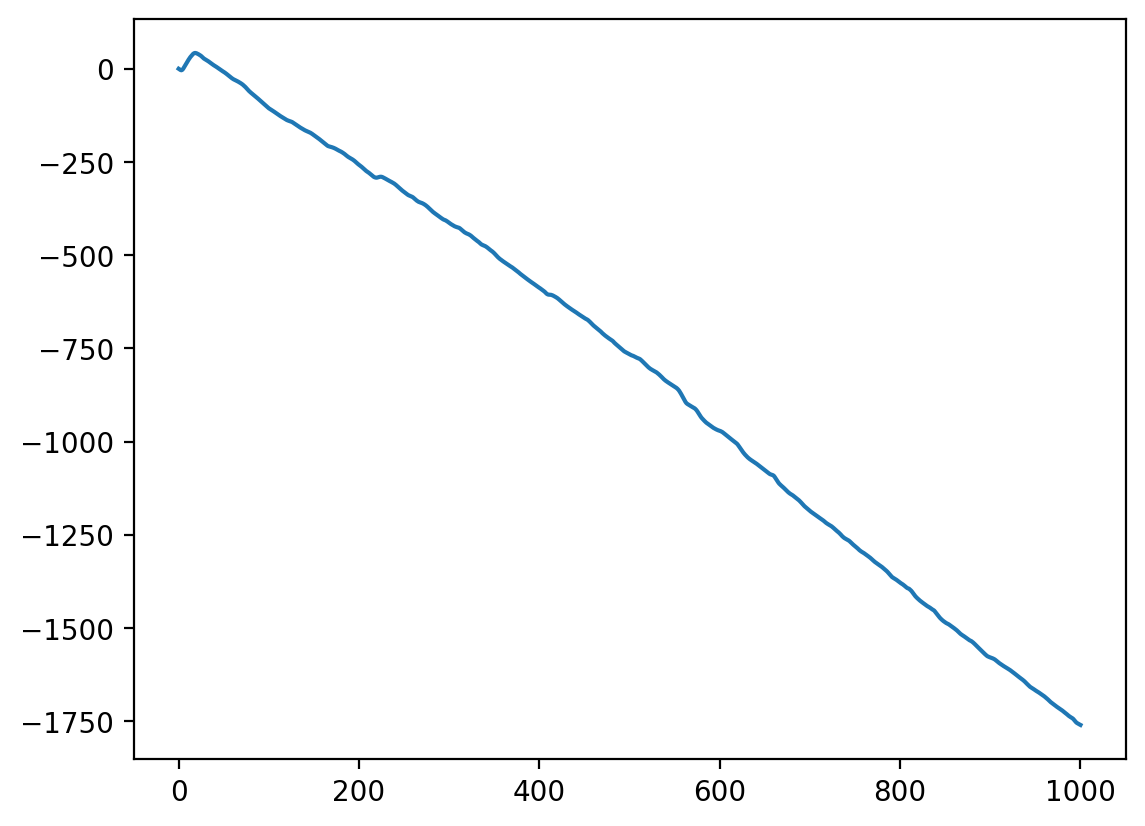

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(np.cumsum(rewards))
plt.show()


In [ ]:
len(qs[0])

74

In [ ]:
def plot_kinematics(qs, up_to, idx=-1, total_len=2000):
    fig = plt.figure(figsize=(5, 5))
    if idx == -1:
        qs = [r.q for r in rollout[:up_to]]
        for _idx in range(len(qs[0])):
            plt.scatter(up_to, qs[up_to-1][_idx], c="r")
    else:
        # qs = [r.subtree_com[1][idx] for r in rollout[:up_to]]
        qs = [r.q[idx] for r in rollout[:up_to]]
        plt.scatter(up_to, qs[up_to-1], c="r")
        
    _ = plt.plot(qs, alpha=0.8)
    plt.xlim(0, total_len)
    plt.ylim(-0.15, 0.15)
    plt.axvline(x=up_to, c="r")
    
    plt.title(f"r.q[{idx}] Trajectory")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    graph = cv2.resize(graph, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
    return graph


def stack_vids(vids, qs, up_to=500, target_idx=2):
    concat_vids = []
    for idx, frame in tqdm(enumerate(vids[:up_to])):
        plot = plot_kinematics(qs, idx+1, idx=target_idx, total_len=up_to)
        total = np.hstack((frame, plot))
        concat_vids.append(total)
    return concat_vids

In [ ]:
import matplotlib
matplotlib.use('svg') 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.

videos = stack_vids(video, qs, target_idx=2)

0it [00:00, ?it/s]

500it [00:14, 34.88it/s]


In [ ]:
media.show_video(videos, fps=30)

In [ ]:
graph.shape

NameError: name 'graph' is not defined

In [ ]:
which = 2
front = 200
qs = [r.q[which] for r in rollout[:front]]
_ = plt.plot(qs, alpha=0.8)
plt.xlim(0, 2000)
plt.axvline(x=front, c="r")
plt.scatter(front, qs[front-1], c="r")
plt.title(f"r.q[{which}] Trajectory")